In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import MSELoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# import
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

# Outlines
- Tensorboard
    - Import package
        - `torch.utils.tensorboard.SummaryWriter`
        - `tb_writer.add_scalar`
        - `tb_writer.add_histogram`
    - Start process
        - `tensorboard --logdir=runs` where `runs` is a folder created automatically in current directory
    - Open interface
        - `http://localhost:6006`
    - Usage
        - 
- Device by `torch.device`
- [Gradient accumulation](https://www.zhihu.com/question/303070254)
- `TensorDataset`

# Simple regression model from `Basic_project_1_regression`

## Data

In [2]:
# dummy training data
n_samples = 100
x_dummy = np.linspace(-3, 3, n_samples)

# cos() function
y_dummy = np.cos(x_dummy) + np.random.uniform(-3, 3, n_samples)

x = torch.tensor(x_dummy).float().view(n_samples, 1)
y = torch.tensor(y_dummy).float().view(n_samples, 1)

src_data = TensorDataset(x, y)

## Model

In [3]:
class RegressionNet(nn.Module):
    def __init__(self, in_features):
        super(RegressionNet, self).__init__()
        self.hidden = nn.Linear(in_features, 10)
        self.output = nn.Linear(10, 1)
    
    def forward(self, x, y=None):
        x = F.relu(self.hidden(x))
        logits = self.output(x)
        outputs = (logits,)
        if y is not None:
            criterion = MSELoss()
            loss = criterion(logits, y)
            outputs = outputs + (loss,)
        return outputs


# model
# if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionNet(1)
model.to(device)

RegressionNet(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

## Train and predict

Epoch: 100%|██████████| 30/30 [00:00<00:00, 30.47it/s]/s]


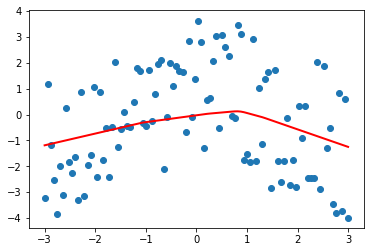

In [4]:
# data
tb_writer = SummaryWriter(comment='summary writer')
#tb_writer.add_graph(model)
train_dataloader = DataLoader(src_data, batch_size=50)

optimizer = optim.SGD(model.parameters(), lr=0.01)

global_step = 0
# gradient accumulation
gradient_accumulation_steps = 2
model.zero_grad()
train_iterator = trange(30, desc='Epoch')
for epoch in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc='Iteration')
    for step, batch in enumerate(epoch_iterator):
        model.train()
        batch = tuple(t.to(device) for t in batch)
        inputs = {'x': batch[0],
                  'y': batch[1]}
        outputs = model(**inputs)
        loss = outputs[1]
        loss = loss / gradient_accumulation_steps
        # backward to compute gradients
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()
            global_step += 1
            # item() to get a number from a tensor containing a single value
            tb_writer.add_scalar('loss', loss.item(), global_step)
    for name, param in model.named_parameters():
        tb_writer.add_histogram(name, param, epoch)
        tb_writer.add_histogram(f'{name}.grad', param.grad, epoch)
    
tb_writer.close()
model.eval()
inputs = {'x': x}
outputs = model(**inputs)
predictions = outputs[0]
plt.scatter(x.numpy(), y.numpy())
plt.plot(x.numpy(), predictions.data.numpy(), 'r', lw=2)
plt.show()